In [1]:
import os
import json
import rasterio
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

from rasterio.windows import from_bounds
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, PredictionErrorDisplay, root_mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from datetime import datetime

EXPERIMENT_NAME = "D2_multi_img"
MODEL = "lightgbm"
MAX_DEPTH = -30
MIN_DEPTH = 0

D2_BAND_RATIOS = [
    ('Band_502', 'Band_569'),
    ('Band_489', 'Band_569'),
    ('Band_519', 'Band_569'),
    ('Band_502', 'Band_549'),
    ('Band_489', 'Band_549'),
    ('Band_569', 'Band_690'),
    ('Band_569', 'Band_832'),
    ('Band_584', 'Band_690'),
    ('Band_569', 'Band_734'),
    ('Band_569', 'Band_721'),
]

D3_BAND_RATIOS = [
    ('Band_503', 'Band_569'),
    ('Band_490', 'Band_569'),
    ('Band_519', 'Band_569'),
    ('Band_503', 'Band_550'),
    ('Band_490', 'Band_550'),
    ('Band_569', 'Band_689'),
    ('Band_569', 'Band_832'),
    ('Band_585', 'Band_689'),
    ('Band_569', 'Band_734'),
    ('Band_569', 'Band_722'),
]

TRAIN_AOI = "../data/aois/wyvern_dragonette-002_20250225T004037_4788dc6b_traintest.geojson"
TRAIN_IMG = "../data/datasets/wyvern_dragonette-002_20250225T004037_4788dc6b.tiff"
LABEL_IMG = "../data/datasets/wyvern_dragonette-002_20250225T004037_4788dc6b_ground_truth.tif"

wyv_palette_values = [
    "#3b26f9",
    "#ff4848",
    "#F4037B",
    "#322c56",
    "#000000",
]
wyv_palette = sns.color_palette(wyv_palette_values, len(wyv_palette_values))

In [64]:
def process_arrays(image_arr, label_arr, filter_depth = True) -> tuple[np.ndarray, np.ndarray]:
    # Flatten/reshape
    img_shp = image_arr.shape
    image_reshaped = np.swapaxes(image_arr.reshape((img_shp[0], img_shp[1] * img_shp[2])), 0, -1)
    label_reshaped = np.swapaxes(label_arr.reshape((1, img_shp[1] * img_shp[2])), 0, -1)

    # Filter for depths greater than -50 (removes NaNs) and less than 0 (removes above water values)
    if filter_depth:
        filt_term = (label_reshaped[:, 0] > MAX_DEPTH) & (label_reshaped[:, 0] < MIN_DEPTH)
        image_reshaped = image_reshaped[filt_term]
        label_reshaped = label_reshaped[filt_term]

    return image_reshaped, label_reshaped

In [66]:
aoi_df = gpd.read_file(TRAIN_AOI)
image_file = rasterio.open(TRAIN_IMG)
labels_file = rasterio.open(LABEL_IMG)

print("Generating windows")
img_window = from_bounds(*aoi_df.total_bounds, transform=image_file.transform)
label_window = from_bounds(*aoi_df.total_bounds, transform=labels_file.transform)

print("Reading in arrays!")
img_arr = image_file.read(window=img_window)
label_arr = labels_file.read(window=label_window)

print("Processing array!")
proc_arr, proc_labels = process_arrays(img_arr, label_arr, filter_depth=True)
print(f"Processed array shape: {proc_arr.shape}, Processed labels shape: {proc_labels.shape}")

Generating windows
Reading in arrays!
Processing array!
Processed array shape: (550600, 31), Processed labels shape: (550600, 1)


In [67]:
proc_labels.shape

(550600, 1)

In [68]:
proc_df = pd.DataFrame(proc_arr, columns=image_file.descriptions)
proc_df

,Band_445,Band_465,Band_480,Band_489,Band_502,Band_509,Band_519,Band_534,Band_549,Band_569,...,Band_721,Band_734,Band_750,Band_765,Band_782,Band_800,Band_815,Band_832,Band_850,Band_870
0,0.033619,0.028285,0.031728,0.030835,0.026880,0.028079,0.036722,0.042537,0.049401,0.046215,...,0.132636,0.173956,0.226377,0.174034,0.230055,0.221728,0.213709,0.218017,0.235121,0.239610
1,0.030710,0.029318,0.030374,0.029939,0.027205,0.028203,0.036381,0.042864,0.050900,0.045699,...,0.133109,0.175618,0.226528,0.174531,0.225573,0.220898,0.213620,0.218158,0.230866,0.239636
2,0.029115,0.029246,0.030829,0.030319,0.027056,0.028262,0.034431,0.044376,0.051514,0.045397,...,0.133834,0.175600,0.227910,0.177351,0.225745,0.220358,0.215167,0.218932,0.231949,0.237470
3,0.028068,0.029755,0.031935,0.033024,0.027992,0.028500,0.034818,0.045164,0.051686,0.046486,...,0.135482,0.175131,0.230449,0.181560,0.227316,0.220826,0.216588,0.222269,0.237299,0.238666
4,0.027702,0.032105,0.032015,0.034416,0.028050,0.027437,0.037011,0.045198,0.051730,0.047326,...,0.135364,0.175610,0.231671,0.183602,0.231142,0.223512,0.217192,0.224021,0.241505,0.241857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550595,0.026327,0.032712,0.031880,0.031756,0.023523,0.017411,0.021273,0.022644,0.022760,0.021429,...,0.037576,0.028352,0.014858,-0.008842,0.005635,0.019411,0.037434,0.028669,0.007632,0.010750
550596,0.023421,0.031817,0.031888,0.032521,0.023087,0.016902,0.021307,0.023936,0.022854,0.020992,...,0.037314,0.028521,0.016247,-0.008823,0.006245,0.017682,0.037716,0.028521,0.007230,0.010748
550597,0.024870,0.034847,0.034844,0.035591,0.021361,0.019964,0.023199,0.021620,0.021039,0.019155,...,0.038209,0.029944,0.015552,-0.009959,0.008703,0.017347,0.036442,0.030873,0.009634,0.012640
550598,0.026053,0.034345,0.033126,0.033837,0.019824,0.020389,0.022567,0.021397,0.021038,0.019668,...,0.039055,0.029922,0.015535,-0.010378,0.007696,0.017161,0.035847,0.029206,0.009498,0.012626


In [69]:
image_file.descriptions

('Band_445',
 'Band_465',
 'Band_480',
 'Band_489',
 'Band_502',
 'Band_509',
 'Band_519',
 'Band_534',
 'Band_549',
 'Band_569',
 'Band_584',
 'Band_600',
 'Band_614',
 'Band_635',
 'Band_650',
 'Band_660',
 'Band_670',
 'Band_680',
 'Band_690',
 'Band_700',
 'Band_712',
 'Band_721',
 'Band_734',
 'Band_750',
 'Band_765',
 'Band_782',
 'Band_800',
 'Band_815',
 'Band_832',
 'Band_850',
 'Band_870')

In [70]:
from itertools import combinations
from sklearn.base import BaseEstimator, TransformerMixin

class StumpfFeatureEngineering(BaseEstimator, TransformerMixin):
    blue_wavelength = 489
    green_wavelength = 550
    red_wavelength = 660

    def __init__(self, band_names):
        self.band_names = band_names

        # Splits "Band_XXX" into integer wavelengths
        self.wavelengths = [
            int(x.split("_")[-1]) for x in band_names
        ]

        self.offsets = [0, 0, 0]  # Offsets for blue, green, red bands
        self.matching_bands = [
            self.__find_nearest_wavelength(x, self.wavelengths)
            for x in [self.blue_wavelength, self.green_wavelength, self.red_wavelength]
        ]
        self.matching_idxs = [self.wavelengths.index(x) for x in self.matching_bands]

    def __find_nearest_wavelength(self, target_wavelength: int, wavelengths: list[int]) -> int:
        """Finds the nearest matching wavelength in a list of wavelengths.

        Args:
            target_wavelength (int): Target wavelength to match, in nanometers.
            wavelengths (list[int]): List of available wavelengths, in nanometers.

        Returns:
            int: Closest matching wavelength from the list.
        """
        array = np.asarray(wavelengths)
        idx = (np.abs(array - target_wavelength)).argmin()
        return array[idx]

    def fit(self, X, y=None):
        self.offsets = [
            np.nanmin(X[self.band_names[idx]])
            for idx in self.matching_idxs
        ]
        return self

    def transform(self, X):
        np.seterr(divide='ignore', invalid='ignore')  # Ignore division by zero warnings
        for name, (idx_1, idx_2) in [
            ("stumpf_blue_green", (0, 1)),
            ("stumpf_blue_red", (0, 2)),
            ("stumpf_green_red", (1, 2)),
        ]:
            # First, calculate stumpf ratio
            X[name] = (
                np.log(
                    X[self.band_names[self.matching_idxs[idx_1]]] +
                    self.offsets[idx_1]
                ) / np.log(
                    X[self.band_names[self.matching_idxs[idx_2]]] +
                    self.offsets[idx_2]
                )
            )
            # Then, let's replace any NaN values with 0
            X[name].fillna(0, inplace=True)
        return X
    
class SimpleRatioFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, band_names):
        self.band_names = band_names
        self.band_ratios = combinations(band_names, 2)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for band_1, band_2 in self.band_ratios:
            X[f"sr_{band_1}_{band_2}"] = X[band_1] / X[band_2]
        return X
    
class NormalizedDifferenceFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, band_names):
        self.band_names = band_names
        self.band_ratios = combinations(band_names, 2)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for band_1, band_2 in self.band_ratios:
            X[f"nd_{band_1}_{band_2}"] = (
                (X[band_1] - X[band_2]) /
                (X[band_1] + X[band_2])
            )
        return X

In [71]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

feat_eng_df = StumpfFeatureEngineering(band_names=image_file.descriptions).fit_transform(proc_df)
feat_eng_df = SimpleRatioFeatureEngineering(band_names=image_file.descriptions).fit_transform(feat_eng_df)
feat_eng_df = NormalizedDifferenceFeatureEngineering(band_names=image_file.descriptions).fit_transform(feat_eng_df)
feat_eng_df

/var/folders/rg/jpb72q99503gth11wv_9p4mh0000gn/T/ipykernel_60810/1210699685.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[name].fillna(0, inplace=True)
/var/folders/rg/jpb72q99503gth11wv_9p4mh0000gn/T/ipykernel_60810/1210699685.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

,Band_445,Band_465,Band_480,Band_489,Band_502,Band_509,Band_519,Band_534,Band_549,Band_569,...,nd_Band_800_Band_815,nd_Band_800_Band_832,nd_Band_800_Band_850,nd_Band_800_Band_870,nd_Band_815_Band_832,nd_Band_815_Band_850,nd_Band_815_Band_870,nd_Band_832_Band_850,nd_Band_832_Band_870,nd_Band_850_Band_870
0,0.033619,0.028285,0.031728,0.030835,0.026880,0.028079,0.036722,0.042537,0.049401,0.046215,...,0.018418,0.008440,-0.029315,-0.038761,-0.009979,-0.047707,-0.057138,-0.037746,-0.047186,-0.009457
1,0.030710,0.029318,0.030374,0.029939,0.027205,0.028203,0.036381,0.042864,0.050900,0.045699,...,0.016750,0.006241,-0.022066,-0.040688,-0.010510,-0.038801,-0.057399,-0.028303,-0.046917,-0.018639
2,0.029115,0.029246,0.030829,0.030319,0.027056,0.028262,0.034431,0.044376,0.051514,0.045397,...,0.011921,0.003248,-0.025626,-0.037376,-0.008673,-0.037535,-0.049274,-0.028871,-0.040619,-0.011761
3,0.028068,0.029755,0.031935,0.033024,0.027992,0.028500,0.034818,0.045164,0.051686,0.046486,...,0.009689,-0.003255,-0.035956,-0.038826,-0.012945,-0.045630,-0.048497,-0.032704,-0.035575,-0.002874
4,0.027702,0.032105,0.032015,0.034416,0.028050,0.027437,0.037011,0.045198,0.051730,0.047326,...,0.014339,-0.001139,-0.038695,-0.039421,-0.015477,-0.053004,-0.053729,-0.037558,-0.038284,-0.000727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550595,0.026327,0.032712,0.031880,0.031756,0.023523,0.017411,0.021273,0.022644,0.022760,0.021429,...,-0.317062,-0.192562,0.435539,0.287135,0.132595,0.661282,0.553780,0.579499,0.454563,-0.169616
550596,0.023421,0.031817,0.031888,0.032521,0.023087,0.016902,0.021307,0.023936,0.022854,0.020992,...,-0.361628,-0.234585,0.419548,0.243902,0.138819,0.678268,0.556450,0.595522,0.452592,-0.195668
550597,0.024870,0.034847,0.034844,0.035591,0.021361,0.019964,0.023199,0.021620,0.021039,0.019155,...,-0.355006,-0.280504,0.285872,0.156948,0.082742,0.581831,0.484935,0.524331,0.419006,-0.134980
550598,0.026053,0.034345,0.033126,0.033837,0.019824,0.020389,0.022567,0.021397,0.021038,0.019668,...,-0.352525,-0.259790,0.287434,0.152246,0.102084,0.581079,0.479059,0.509200,0.396359,-0.141375


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor

X_train, X_test, y_train, y_test = train_test_split(
    feat_eng_df,
    proc_labels,
    test_size=0.2,
    random_state=42
)

estimator = LGBMRegressor(random_state=42)
selector = RFE(estimator, n_features_to_select=20, step=100)

In [73]:
selector.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.944056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245820
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 964
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.369511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220320
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 864
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.723716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194820
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 764
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.545985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169320
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 664
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.445181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143820
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 564
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118320
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 464
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92820
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 364
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67320
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 264
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41820
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 164
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 64
[LightGBM] [Info] Start training from score -8.542705


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 440480, number of used features: 20
[LightGBM] [Info] Start training from score -8.542705


,estimator,LGBMRegressor(random_state=42)
,n_features_to_select,20
,step,100
,verbose,0
,importance_getter,'auto'
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000


In [74]:
selected_features = feat_eng_df.columns[selector.support_]
selected_sr_feats = list(filter(lambda x: "sr_B" in x, selected_features))
selected_nd_feats = list(filter(lambda x: "nd_B" in x, selected_features))

print(
    f"Total selected simple ratio features: {len(selected_sr_feats)}\n"
    f"Total selected normalized difference features: {len(selected_nd_feats)}"
)
selected_features

Total selected simple ratio features: 7
Total selected normalized difference features: 5


Index(['Band_465', 'Band_489', 'Band_569', 'Band_600', 'Band_680', 'Band_800',
       'Band_850', 'Band_870', 'sr_Band_445_Band_502', 'sr_Band_445_Band_584',
       'sr_Band_465_Band_509', 'sr_Band_480_Band_569', 'sr_Band_480_Band_750',
       'sr_Band_489_Band_734', 'sr_Band_509_Band_680', 'nd_Band_445_Band_782',
       'nd_Band_465_Band_534', 'nd_Band_519_Band_870', 'nd_Band_534_Band_680',
       'nd_Band_712_Band_782'],
      dtype='object')

In [75]:
print("Selected Simple Ratios:")
[(x.replace("sr_", "")[:8], x.replace("sr_", "")[9:]) for x in selected_sr_feats]

Selected Simple Ratios:


[('Band_445', 'Band_502'),
 ('Band_445', 'Band_584'),
 ('Band_465', 'Band_509'),
 ('Band_480', 'Band_569'),
 ('Band_480', 'Band_750'),
 ('Band_489', 'Band_734'),
 ('Band_509', 'Band_680')]

In [76]:
print("Selected Normalized Difference Ratios:")
[(x.replace("nd_B", "B")[:8], x.replace("nd_B", "B")[9:]) for x in selected_nd_feats]

Selected Normalized Difference Ratios:


[('Band_445', 'Band_782'),
 ('Band_465', 'Band_534'),
 ('Band_519', 'Band_870'),
 ('Band_534', 'Band_680'),
 ('Band_712', 'Band_782')]

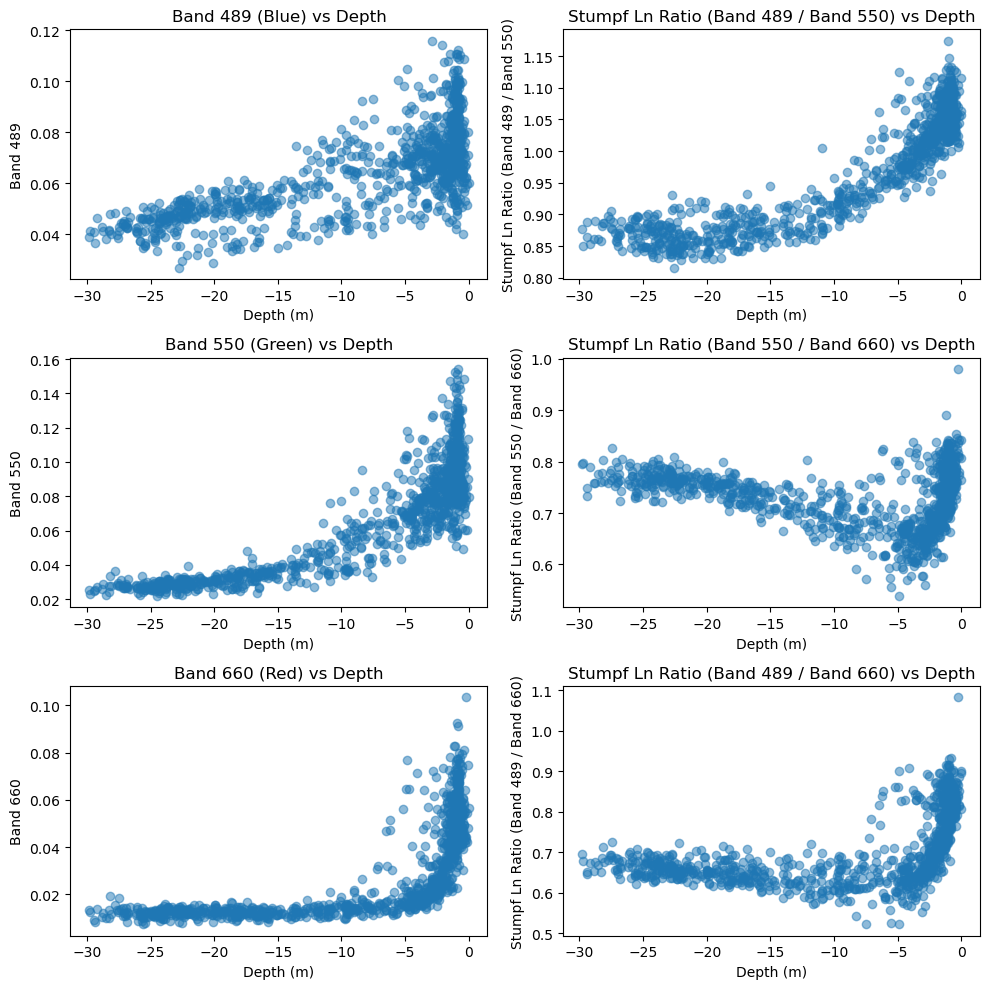

In [83]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

feat_eng_df["depth"] = proc_labels
sampled_df = feat_eng_df.sample(1000)

axs[0, 0].scatter(sampled_df["depth"], sampled_df["Band_489"], alpha=0.5)
axs[0, 0].set_xlabel('Depth (m)')
axs[0, 0].set_ylabel('Band 489')
axs[0, 0].set_title('Band 489 (Blue) vs Depth')


axs[0, 1].scatter(sampled_df["depth"], sampled_df["stumpf_blue_green"], alpha=0.5)
axs[0, 1].set_xlabel('Depth (m)')
axs[0, 1].set_ylabel('Stumpf Ln Ratio (Band 489 / Band 550)')
axs[0, 1].set_title('Stumpf Ln Ratio (Band 489 / Band 550) vs Depth')


axs[1, 0].scatter(sampled_df["depth"], sampled_df["Band_549"], alpha=0.5)
axs[1, 0].set_xlabel('Depth (m)')
axs[1, 0].set_ylabel('Band 550')
axs[1, 0].set_title('Band 550 (Green) vs Depth')

axs[1, 1].scatter(sampled_df["depth"], sampled_df["stumpf_green_red"], alpha=0.5)
axs[1, 1].set_xlabel('Depth (m)')
axs[1, 1].set_ylabel('Stumpf Ln Ratio (Band 550 / Band 660)')
axs[1, 1].set_title('Stumpf Ln Ratio (Band 550 / Band 660) vs Depth')


axs[2, 0].scatter(sampled_df["depth"], sampled_df["Band_660"], alpha=0.5)
axs[2, 0].set_xlabel('Depth (m)')
axs[2, 0].set_ylabel('Band 660')
axs[2, 0].set_title('Band 660 (Red) vs Depth')

axs[2, 1].scatter(sampled_df["depth"], sampled_df["stumpf_blue_red"], alpha=0.5)
axs[2, 1].set_xlabel('Depth (m)')
axs[2, 1].set_ylabel('Stumpf Ln Ratio (Band 489 / Band 660)')
axs[2, 1].set_title('Stumpf Ln Ratio (Band 489 / Band 660) vs Depth')

plt.tight_layout()